In [228]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional  as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import os
import cv2
import random
# %run vertebra_count.ipynb

In [229]:
def dfs(segment, x, y, ans, visited):
    visited.add((x, y))
    ans.append((x, y))
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:           
            if x-i>=0 and y-j>=0 and x-i<segment.shape[0] and y-j<segment.shape[1] and (not (x-i, y-j) in visited) and segment[x-i][y-j]==1:
                dfs(segment, x-i, y-j, ans, visited)
    return ans


def segmentation(segment):
    visited = set()
    ans = []
    for i in range(segment.shape[0]):
        for j in range(segment.shape[1]):
            if not ((i , j) in visited) and segment[i][j]==1:
                ans.append(dfs(segment, i, j, [], visited))
    return ans

In [243]:
lr = 0.0008
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch = 160
batch = 4
w = 250
h = 250

In [250]:
class vertebra:
    def __init__(self,train=True):
        path = '../Lab/vertebra/data'
        if train:            
            folder = ['f01/image', 'f02/image']#, 'f03/image']
            folder_label = ['f01/label', 'f02/label']#, 'f03/label']
        else:
            folder = ['f02/image']
            folder_label = ['f02/label']
        imgs = []
        labels = []
        for i,f in enumerate(folder):
            p = os.path.join(path,f)
            p_l = os.path.join(path,folder_label[i])
            file = os.listdir(p)
            file_l = os.listdir(p_l)
            imgs += [os.path.join(p, x) for x in file]
            labels += [os.path.join(p_l, x) for x in file_l]
        self.l = len(imgs)
        self.imgs = imgs
        self.labels = labels
        self.train = train    
    def __getitem__(self, index):
        if self.train:
            f = random.choice([1,2,3,4])
            if f==1:
                return transform1(Image.open(self.imgs[index])).float(),transform1(Image.open(self.labels[index])).float()
            if f==2:
                return transform2(Image.open(self.imgs[index])).float(),transform2(Image.open(self.labels[index])).float()
            if f==3:
                return transform3(Image.open(self.imgs[index])).float(),transform3(Image.open(self.labels[index])).float()
            if f==4:
                return transform4(Image.open(self.imgs[index])).float(),transform4(Image.open(self.labels[index])).float()
        else:
            return transform1(Image.open(self.imgs[index])).float(),transform1(Image.open(self.labels[index])).float()
    def __len__(self):
        return self.l

transform1 = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop(1200),
    transforms.Resize([w,h]),
    transforms.ToTensor()
#     transforms.Normalize(mean=[0.485], std=[0.229])
])

transform2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop(1200),
    transforms.Resize([w,h]),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor()
#     transforms.Normalize(mean=[0.485], std=[0.229])
])

transform3 = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop(1200),
    transforms.Resize([w,h]),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
#     transforms.Normalize(mean=[0.485], std=[0.229])
])

transform4 = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop(1200),
    transforms.Resize([w,h]),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
#     transforms.Normalize(mean=[0.485], std=[0.229])
])

In [245]:
dataset = vertebra()
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch,shuffle=True)

In [246]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)                 


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        self.s = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.s(logits)

In [247]:
model = UNet(1,1).to(device)
model.train()
criterion = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(),lr=lr)

In [248]:
for k in range(epoch):
    for i, (x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
#         print(pred)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i%10000==0:
            print(f'epoch={k}, loss={loss:.3f}')

epoch=0, loss=0.821
epoch=1, loss=0.444
epoch=2, loss=0.353
epoch=3, loss=0.290
epoch=4, loss=0.259
epoch=5, loss=0.226
epoch=6, loss=0.204
epoch=7, loss=0.180
epoch=8, loss=0.170
epoch=9, loss=0.153
epoch=10, loss=0.142
epoch=11, loss=0.124
epoch=12, loss=0.120
epoch=13, loss=0.113
epoch=14, loss=0.104
epoch=15, loss=0.100
epoch=16, loss=0.091
epoch=17, loss=0.085
epoch=18, loss=0.084
epoch=19, loss=0.075
epoch=20, loss=0.070
epoch=21, loss=0.067
epoch=22, loss=0.059
epoch=23, loss=0.064
epoch=24, loss=0.055
epoch=25, loss=0.055
epoch=26, loss=0.055
epoch=27, loss=0.053
epoch=28, loss=0.048
epoch=29, loss=0.047
epoch=30, loss=0.046
epoch=31, loss=0.043
epoch=32, loss=0.048
epoch=33, loss=0.046
epoch=34, loss=0.041
epoch=35, loss=0.039
epoch=36, loss=0.042
epoch=37, loss=0.041
epoch=38, loss=0.036
epoch=39, loss=0.037
epoch=40, loss=0.039
epoch=41, loss=0.039
epoch=42, loss=0.035
epoch=43, loss=0.038
epoch=44, loss=0.032
epoch=45, loss=0.036
epoch=46, loss=0.035
epoch=47, loss=0.033
ep

In [236]:
def set_to_integer(pred):
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if(pred[i][j]<0.45):
                pred[i][j] = 0
            else:
                pred[i][j] = 1

In [237]:
def count_number_of_vertebrae(dataset, model):
    for x,y in dataset:
        y = y.view(w,h).numpy()       
        num_label = len(segmentation(y))
        x = x.view(1,x.shape[0], x.shape[1], x.shape[2]).to(device)
        pred = model(x)
        pred = pred.detach().view(w,h).to('cpu').numpy()
        set_to_integer(pred)
        num_pred = len(segmentation(pred))
        print(f'num_label = {num_label}, num_pred = {num_pred}')

In [238]:
def DC(dataset, model):
    for x,y in dataset:
        x = x.view(1,x.shape[0], x.shape[1], x.shape[2]).to(device)
        y = y.view(w,h).numpy()
        pred = model(x)
        pred = pred.detach().view(w,h).to('cpu').numpy()
        set_to_integer(pred)
        tp=tn=fp=fn=0
        for i in range(w):
            for j in range(h):
                if pred[i][j]==y[i][j]:
                    if pred[i][j]==0:
                        tn+=1;
                    else:
                        tp+=1;
                else:
                    if pred[i][j]==0:
                        fn+=1;
                    else:
                        fp+=1;
        
        print(f'DC = {tp*2/(2*tp+fn+fp):.3f}')         

In [239]:
def show_img(dataset, model):
    for i,(x,y) in enumerate(dataset):
        x = x.view(1,x.shape[0], x.shape[1], x.shape[2]).to(device)
        y = t(y).view(1200,1200).numpy()
        pred = model(x)
        pred = t(pred.detach()).view(1200,1200).to('cpu').numpy()
        set_to_integer(pred)
#         plt.figure()
#         plt.subplot(1,2,1)
        plt.imshow(pred,cmap='Greys')
#         plt.subplot(1,2,2)
#         plt.imshow(y,cmap='Greys')
        plt.savefig("../Lab/vertebra/data/f03/prediction/vertebrae{}.png".format(i))

In [ ]:
# model.load_state_dict(torch.load("vertebra.path"))
# model.eval()
# test_dataset = vertebra(False)
# count_number_of_vertebrae(test_dataset, model)
# DC(test_dataset, model)

In [ ]:
# show_img(test_dataset, model)

In [ ]:
def checkpoint():
    path = "vertebra.path"
    torch.save(model.state_dict(),path)

In [ ]:
# checkpoint()

number of components = 17
number of components = 18
number of components = 18
number of components = 16
number of components = 16
number of components = 17
number of components = 18
number of components = 17
number of components = 19
number of components = 18
number of components = 18
number of components = 18
number of components = 18
number of components = 18
number of components = 16
number of components = 18
number of components = 17
number of components = 17
number of components = 16
number of components = 17


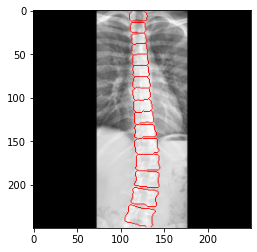

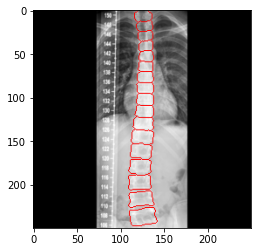

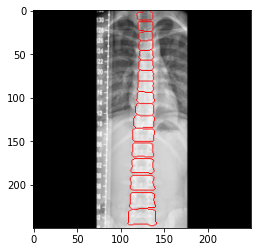

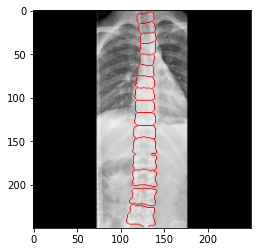

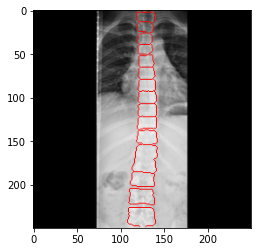

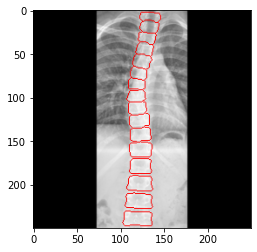

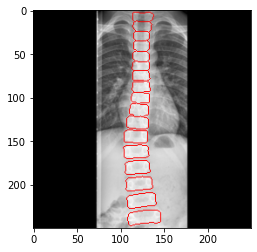

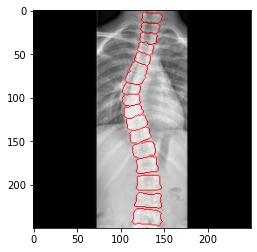

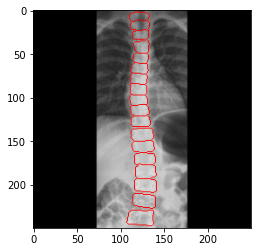

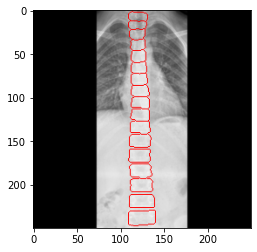

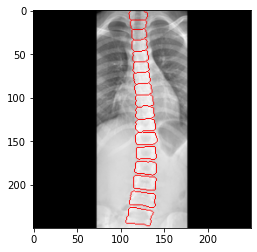

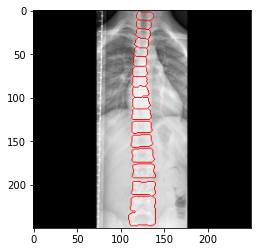

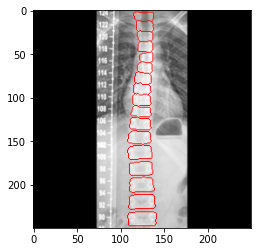

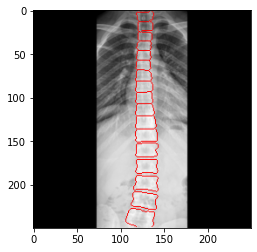

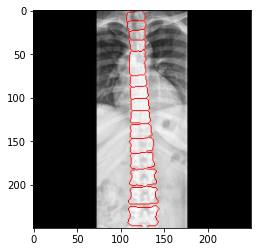

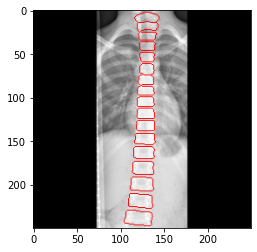

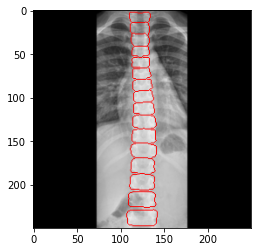

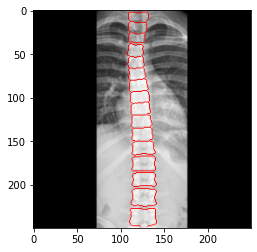

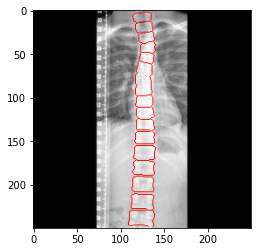

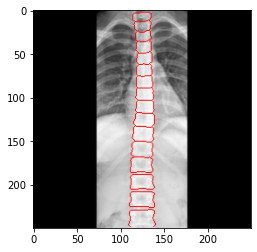

In [251]:
test = vertebra(False)
model.eval()
for i in range(len(test)):
    x_ray = test[i][0].unsqueeze(0).to(device)
    pred = model(x_ray)
    x_ray = x_ray[0,0].to('cpu').numpy()
#     x_ray *= 255
    x_ray = cv2.merge((x_ray,x_ray,x_ray))
    pred = pred.detach().to('cpu').numpy()
    label = pred[0,0,:,:]
    img = cv2.merge((label,label,label))
    img = (img[:,:]>0.5).astype(np.uint8)
#     with np.printoptions(threshold=np.inf):
#         print(x_ray)
    img *= 255
#     plt.figure()
#     plt.imshow(x_ray, cmap='gray')
    set_to_integer(label)
    label = np.uint8(label)
    _, thres = cv2.threshold(label,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    thres = cv2.morphologyEx(thres,cv2.MORPH_OPEN,kernel,iterations=1)
    sure_bk = cv2.dilate(thres,kernel,iterations=5)
    dist = cv2.distanceTransform(thres,cv2.DIST_L2,5)
    _, sure_fg = cv2.threshold(dist,0.25*dist.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bk,sure_fg)
    num, marker = cv2.connectedComponents(sure_fg)
    marker+=10
    print(f'number of components = {num}')
    marker[unknown==255] = 0
    marker = cv2.watershed(img,marker)
    marker[(0,249),:] = 0
    marker[:,(0,249)] = 0
    x_ray[marker==-1] = [1,0,0]
    plt.figure()
    plt.imshow(x_ray,cmap='gray')

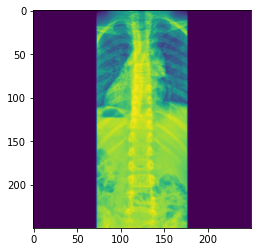

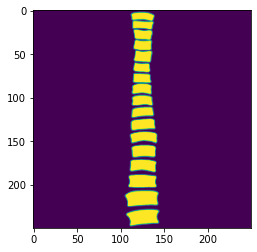

In [225]:
test = vertebra(False)
y = test[0][0][0]
x = test[0][1][0]
plt.figure()
plt.imshow(y.numpy())
plt.figure()
plt.imshow(x.numpy())